In [12]:
import numpy as np
import pandas as pd
import os
import scipy.io
from scipy.signal import butter, filtfilt, iirnotch, cheby2
from einops import rearrange
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [3]:
import sys

sys.path.append("../../motor-imagery-classification-2024/")

from loaders import EEGDataset,load_data
from models.unet.eeg_unets import Unet,UnetConfig

c:\Users\rahar\anaconda3\envs\neuro\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [4]:
FS = 250
sns.set_style("darkgrid")

In [5]:
dataset = {}
for i in range(1,10):
	mat_train,mat_test = load_data("../data/2b_iv",i)
	dataset[f"subject_{i}"] = {"train":mat_train,"test":mat_test}

In [6]:
import torch.nn.functional as F
from einops import reduce

class FakeClassifier(nn.Module):
    def __init__(self, input_channels):
        super(FakeClassifier, self).__init__()
        self.fc = nn.Linear(input_channels, 2) 

    def forward(self, x):
        x = reduce(x,"b c ... -> b c","mean")
        x = self.fc(x)
        return x


In [7]:
class DeepClassifier:
    def __init__(self, 
                 mat_dataset,
                 train_split,
                 test_split,
                 batch_size=32, 
                 t_baseline=0, 
                 t_epoch=9, 
                 fs=250,
                 start=3.5,
                 length=2):
        self.fs = fs
        self.t_epoch = t_epoch
        self.t_baseline = t_baseline
        self.batch_size = batch_size
        self.train_loader = self.get_loader(mat_dataset,train_split, batch_size)
        self.val_loader = self.get_loader(mat_dataset,test_split,batch_size)
        self.model = FakeClassifier(input_channels=6)  # Define your input channels here

    def get_loader(self,dataset,splits,batch_size,shuffle=True):
        dset = EEGDataset(dataset,splits,fs=self.fs,t_baseline=self.t_baseline,t_epoch=
                          self.t_epoch)
        return DataLoader(dset,batch_size,shuffle=shuffle)

    def get_val_loader(self, mat_dataset):
        val_dataset = EEGDataset(mat_dataset, train=False, fs=self.fs, t_baseline=self.t_baseline, t_epoch=self.t_epoch)
        return DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)

    def fit(self, num_epochs=10):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)

        self.model.to(device)
        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in self.train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_accuracy = 100 * correct / total
            val_loss = 0.0
            correct = 0
            total = 0
            self.model.eval()
            with torch.no_grad():
                for inputs, labels in self.val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = self.model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    val_loss += criterion(outputs, labels).item()

            val_accuracy = 100 * correct / total

            print(f'Epoch [{epoch+1}/{num_epochs}], '
                f'Training Loss: {running_loss/len(self.train_loader):.3f}, '
                f'Training Accuracy: {train_accuracy:.2f}%, '
                f'Validation Loss: {val_loss/len(self.val_loader):.3f}, '
                f'Validation Accuracy: {val_accuracy:.2f}%')

        print('Finished Training')
    
    def predict(self,x):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.eval()
        inputs = inputs.to(device)
        with torch.no_grad():
            outputs = self.model(inputs)
            _, predicted = torch.max(outputs.data, 1)
        return predicted


In [8]:
train_split = 6*[["train","test"]] + 3*[["train"]]
test_split = 6*[[]] + 3* [["test"]]

In [9]:
deep_clf = DeepClassifier(dataset,train_split,test_split)

In [10]:
deep_clf.fit(25)

Epoch [1/25], Training Loss: 0.867, Training Accuracy: 55.90%, Validation Loss: 0.571, Validation Accuracy: 70.16%
Epoch [2/25], Training Loss: 0.744, Training Accuracy: 59.34%, Validation Loss: 0.508, Validation Accuracy: 73.55%
Epoch [3/25], Training Loss: 0.695, Training Accuracy: 61.71%, Validation Loss: 0.504, Validation Accuracy: 75.53%
Epoch [4/25], Training Loss: 0.670, Training Accuracy: 62.59%, Validation Loss: 0.496, Validation Accuracy: 76.24%
Epoch [5/25], Training Loss: 0.660, Training Accuracy: 63.16%, Validation Loss: 0.481, Validation Accuracy: 77.93%
Epoch [6/25], Training Loss: 0.651, Training Accuracy: 63.95%, Validation Loss: 0.462, Validation Accuracy: 78.22%
Epoch [7/25], Training Loss: 0.646, Training Accuracy: 64.17%, Validation Loss: 0.454, Validation Accuracy: 79.21%
Epoch [8/25], Training Loss: 0.643, Training Accuracy: 64.54%, Validation Loss: 0.451, Validation Accuracy: 80.06%
Epoch [9/25], Training Loss: 0.638, Training Accuracy: 64.85%, Validation Loss: 

- Logistic regression reaches 65% train, 80% test (probably lucky splits)

In [11]:
batch = next(iter(deep_clf.train_loader))

In [14]:
batch[0].shape

torch.Size([32, 6, 500])

In [36]:
widths = np.geomspace(1, 1024, num=64)

In [37]:
x = rearrange(batch[0],"b c l -> (b c) l")

In [38]:
y = pywt.cwt(x.numpy(),widths,"cmor1.5-1.0")

In [39]:
x.shape

torch.Size([192, 500])

In [40]:
y[0].shape

(64, 192, 500)

In [41]:
y[1].shape

(64,)

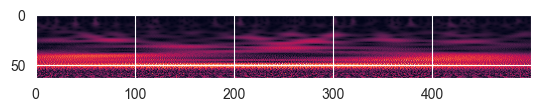

In [42]:
plt.imshow(np.abs(y[0][:,0,:]))

In [57]:
decomp = pywt.wavedec(x,"db2",level=6)

In [78]:
decomp

[array([[-20.709484 , -22.04742  ,   5.7081714, ...,  13.961999 ,
          -2.7111135,  12.331214 ],
        [-10.066859 , -13.1399765,  -2.9790602, ...,  16.81889  ,
         -14.576578 ,   8.744614 ],
        [ -9.385086 , -11.4127245,  -0.5536952, ...,  11.797388 ,
          -2.9622617,  18.53124  ],
        ...,
        [-10.090132 ,  -3.2127898, -55.49938  , ...,  -7.187612 ,
          11.838281 , -15.807021 ],
        [ -5.9294662,  -2.4179304, -63.13102  , ..., -15.164902 ,
          25.194443 ,  -3.4671803],
        [-84.011986 , -78.4836   , -89.701675 , ...,  -8.419716 ,
         -20.906328 ,  38.143772 ]], dtype=float32),
 array([[ -0.55283165,  -6.8227854 ,   6.83294   , ...,   6.948596  ,
          -7.1416717 ,   8.532338  ],
        [  0.36673278, -10.255363  ,   4.628953  , ...,  -0.7422917 ,
          -3.6778584 ,   7.5811405 ],
        [  0.14432871,  -7.089609  ,   8.926609  , ...,   3.660676  ,
          -9.895676  ,  11.955727  ],
        ...,
        [ -1.0318239 

In [79]:
x_full = []
for i in decomp:
	print(i.shape)
	xi = rearrange(i,"(b c) l -> b c l",b=32)
	xi = reduce(xi,"b c l -> b c","mean")
	x_full.append(xi)
np.concatenate(x_full,-1).shape

(192, 10)
(192, 10)
(192, 18)
(192, 34)
(192, 65)
(192, 127)
(192, 251)


(32, 42)

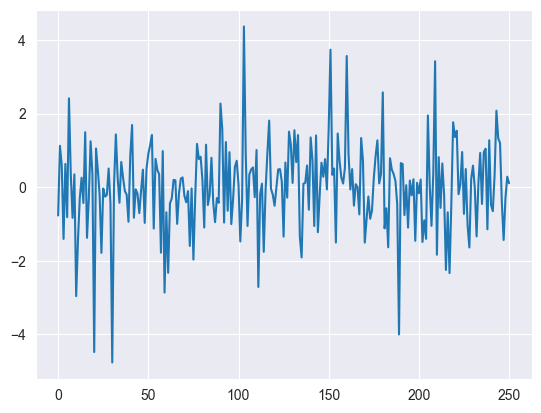

In [56]:
plt.plot(decomp[6][0])

In [80]:
class WaveletDataset(EEGDataset):

	def __init__(self, dataset, subject_splits, fs=250, t_baseline=0, t_epoch=9, start=3.5, length=0.5):
		self.fs = fs
		self.t_baseline = t_baseline
		self.t_epoch = t_epoch
		self.set_epoch(start,length)
		self.data = self.load_data(dataset,subject_splits)

	def __getitem__(self, idx):
		x,y = self.data[0][idx,:,int(self.input_start*250):int(self.input_end*250)], self.data[1][idx]
		b,c,l = x.shape
		x = rearrange(x,"b c l -> (b c) l")
		decomp = pywt.wavedec(x,"db2",level=6)
		x_full = []
		for i in decomp:
			xi = rearrange(i,"(b c) l -> b c l",b=32)
			xi = reduce(xi,"b c l -> b c","mean")
			x_full.append(xi)
		x = np.concatenate(x_full,-1)
		return x,y

In [81]:
wdset = WaveletDataset(dataset,train_split)